# Sequence Space Analysis

In this notebook, we will be analyzing the sequence space spanned by the N2ases. For that, we will consider a network approach, where sequences are placed in regions of an abstract "sequence space" by their identity with other sequences. Although we could make this analysis quite complicated, we will simply define our networks by cutting at some specific threshold.

In [1]:
import networkx as nx
from Bio import AlignIO as aliio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tqdm
plt.rcParams['svg.fonttype'] = 'none'

## Loading the data

Our starting points are just the MSAs.

In [39]:
def alignment_to_df(file):
    out = []
    for sequence in aliio.read(file, format='fasta'):
        out.append(dict(id=sequence.id, seq=str(sequence.seq)))
    return pd.DataFrame.from_records(out)

In [40]:
aln_D = alignment_to_df('../sequences/AGNifAlign105.ext-anc.alt.D.fasta')
aln_K = alignment_to_df('../sequences/AGNifAlign105.ext-anc.alt.K.fasta')
aln_H = alignment_to_df('../sequences/AGNifAlign105.ext-anc.alt.H.fasta')
aln_DK = pd.merge(aln_D, aln_K, on='id', suffixes=['_D', '_K'])
aln_DKH = pd.merge(aln_DK, aln_H, on='id', how='inner').rename(columns={'seq': 'seq_H'})
del aln_DK, aln_D, aln_H, aln_K
aln_DKH

,id,seq_D,seq_K
0,1207_alt4,-------------MSKK-----------------------------...,----------------------------------------------...
1,1207_alt5,-------------MSEN-----------------------------...,----------------------------------------------...
2,1207_map,-------------MSEK-----------------------------...,----------------------------------------------...
3,1207_alt2,-------------MSED-----------------------------...,----------------------------------------------...
4,1207_alt3,-------------MSTK-----------------------------...,----------------------------------------------...
...,...,...,...
2684,Nif_archaeon_BMS3Bbin15,----------------------------------------------...,----------------------------------------------...
2685,Nif_Candidatus_Viridilinea_mediisalina,----------------------------------------------...,----------------------------------------------...
2686,Nif_Chloroflexales_bacterium_ZM16-3,----------------------------------------------...,----------------------------------------------...
2687,Nif_Oscillochloris_trichoides,----------------------------------------------...,----------------------------------------------...


In [4]:
aln_DKH['DDKK'] = aln_DKH.apply(lambda x: x.seq_D + x.seq_K, axis=1)
aln_DKH

,id,seq_D,seq_K,seq_H,DDKK
0,1207_alt4,-------------MSKK-----------------------------...,----------------------------------------------...,----------------------------------------------...,-------------MSKK-----------------------------...
1,1207_alt5,-------------MSEN-----------------------------...,----------------------------------------------...,----------------------------------------------...,-------------MSEN-----------------------------...
2,1207_map,-------------MSEK-----------------------------...,----------------------------------------------...,----------------------------------------------...,-------------MSEK-----------------------------...
3,1207_alt2,-------------MSED-----------------------------...,----------------------------------------------...,----------------------------------------------...,-------------MSED-----------------------------...
4,1207_alt3,-------------MSTK-----------------------------...,----------------------------------------------...,----------------------------------------------...,-------------MSTK-----------------------------...
...,...,...,...,...,...
2684,Nif_archaeon_BMS3Bbin15,----------------------------------------------...,----------------------------------------------...,----------------------------------------------...,----------------------------------------------...
2685,Nif_Candidatus_Viridilinea_mediisalina,----------------------------------------------...,----------------------------------------------...,----------------------------------------------...,----------------------------------------------...
2686,Nif_Chloroflexales_bacterium_ZM16-3,----------------------------------------------...,----------------------------------------------...,----------------------------------------------...,----------------------------------------------...
2687,Nif_Oscillochloris_trichoides,----------------------------------------------...,----------------------------------------------...,----------------------------------------------...,----------------------------------------------...


In [41]:
def compute_identity(seq1, seq2):
    counter = 0
    for a, b in filter(lambda x: x[0] != '-' and x[1] != 'y', zip(seq1, seq2)):
        if a == b:
            counter +=1
    return counter / min(len(seq1.replace('-', '')), len(seq2.replace('-', '')))

assert(compute_identity('AAAAAA', 'AAAAAA') == 1.0)
assert(compute_identity('AAAAAA', 'BBBBBB') == 0.0)
assert(compute_identity('AAAAAA', '-----B') == 0.0)

In [42]:
def find_alternatives(x):
    for tag in ['_alt1', '_alt2', '_alt3', '_alt4', '_alt5', '_altall']:
        if x.find(tag) != -1:
            return True
    return False

assert(find_alternatives('sadasad_alt1') is True)
assert(find_alternatives('sadasad_alernaria') is False)
assert(find_alternatives('sadasad_ale') is False)

In [43]:
def place_anc_tag(x):
    try:
        int(x.split('_')[0])
        return 'Anc_' + x
    except:
        return x

aln_DKH['id'] = aln_DKH['id'].apply(place_anc_tag)
aln_DKH['type'] = aln_DKH['id'].apply(lambda x: x.split('_')[0])
aln_DKH['variant'] = aln_DKH['id'].apply(find_alternatives)
aln_DKH

,id,seq_D,seq_K,type,variant
0,Anc_1207_alt4,-------------MSKK-----------------------------...,----------------------------------------------...,Anc,True
1,Anc_1207_alt5,-------------MSEN-----------------------------...,----------------------------------------------...,Anc,True
2,Anc_1207_map,-------------MSEK-----------------------------...,----------------------------------------------...,Anc,False
3,Anc_1207_alt2,-------------MSED-----------------------------...,----------------------------------------------...,Anc,True
4,Anc_1207_alt3,-------------MSTK-----------------------------...,----------------------------------------------...,Anc,True
...,...,...,...,...,...
2684,Nif_archaeon_BMS3Bbin15,----------------------------------------------...,----------------------------------------------...,Nif,False
2685,Nif_Candidatus_Viridilinea_mediisalina,----------------------------------------------...,----------------------------------------------...,Nif,False
2686,Nif_Chloroflexales_bacterium_ZM16-3,----------------------------------------------...,----------------------------------------------...,Nif,False
2687,Nif_Oscillochloris_trichoides,----------------------------------------------...,----------------------------------------------...,Nif,False


In [44]:
aln_DKH_noalt = aln_DKH.query('variant == False').copy()
aln_DKH_noalt

,id,seq_D,seq_K,type,variant
2,Anc_1207_map,-------------MSEK-----------------------------...,----------------------------------------------...,Anc,False
9,Anc_1213_map,-------------MSEKK----------------------VK----...,------MSE-AAAV--------------------------------...,Anc,False
18,Anc_1215_map,-------------MSERK----------------------------...,------MSA-EAAV--------------------------------...,Anc,False
21,Anc_1214_map,-------------MSERK----------------------------...,------MSA-EAAV--------------------------------...,Anc,False
29,Anc_1216_map,-------------MSEK-----------------------IK----...,------MAN-ALGL--------------------------------...,Anc,False
...,...,...,...,...,...
2684,Nif_archaeon_BMS3Bbin15,----------------------------------------------...,----------------------------------------------...,Nif,False
2685,Nif_Candidatus_Viridilinea_mediisalina,----------------------------------------------...,----------------------------------------------...,Nif,False
2686,Nif_Chloroflexales_bacterium_ZM16-3,----------------------------------------------...,----------------------------------------------...,Nif,False
2687,Nif_Oscillochloris_trichoides,----------------------------------------------...,----------------------------------------------...,Nif,False


## Computing sequence identity

In [45]:
sequence_similarity_matrix = []

for i1, seq1 in tqdm.tqdm(aln_DKH_noalt.iterrows(), total=len(aln_DKH_noalt)):
    for i2, seq2 in aln_DKH_noalt.iterrows():
        sequence_similarity_matrix.append(
            dict(
                id1=seq1.id, id2=seq2.id, 
                identity=compute_identity(seq1['DDKK'], seq2['DDKK']),
                type1=seq1.type, type2=seq2.type
            )
        )

sequence_similarity_matrix = pd.DataFrame.from_records(sequence_similarity_matrix)

  0%|          | 0/769 [00:00<?, ?it/s]


KeyError: 'DDKK'

/home/bcz/miniconda3/envs/e24/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/bcz/miniconda3/envs/e24/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


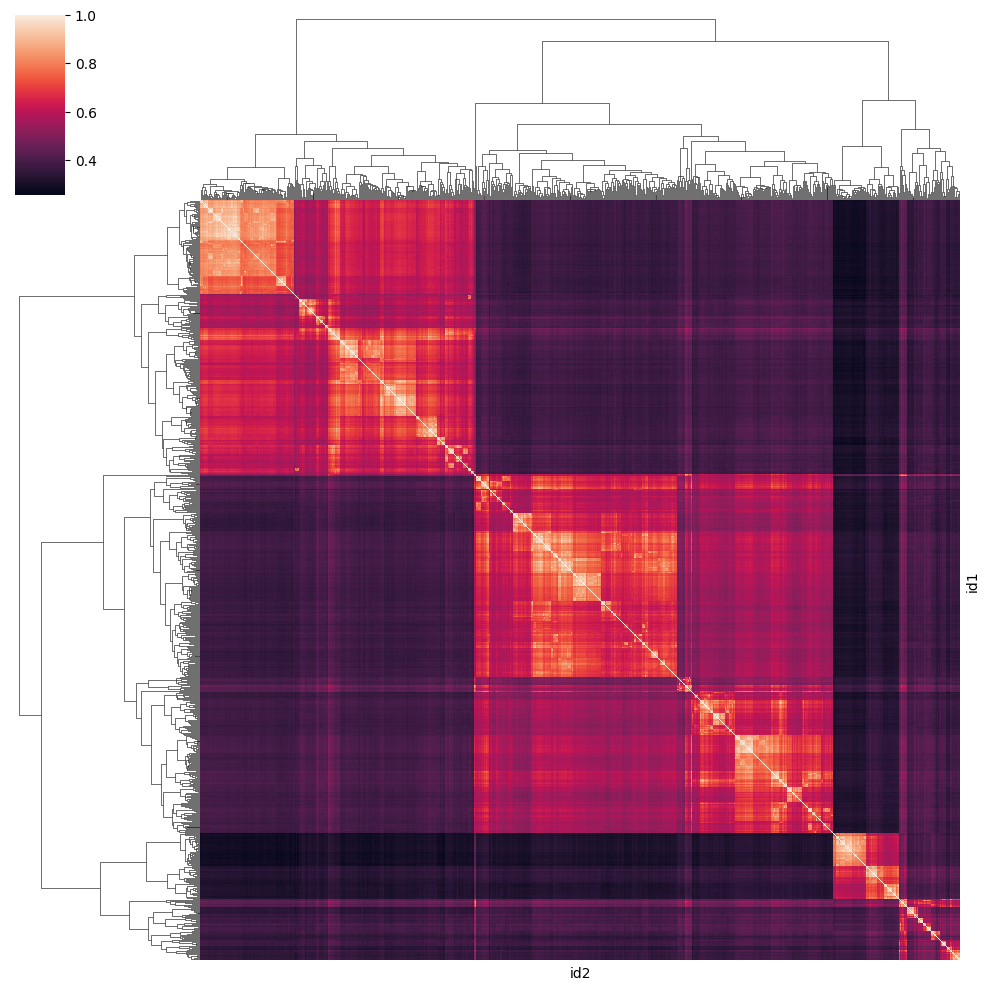

In [10]:
sequence_similarity_matrix_pivot = pd.pivot(data=sequence_similarity_matrix, index='id1', columns='id2', values='identity')
sns.clustermap(sequence_similarity_matrix_pivot, yticklabels=False,xticklabels=False)

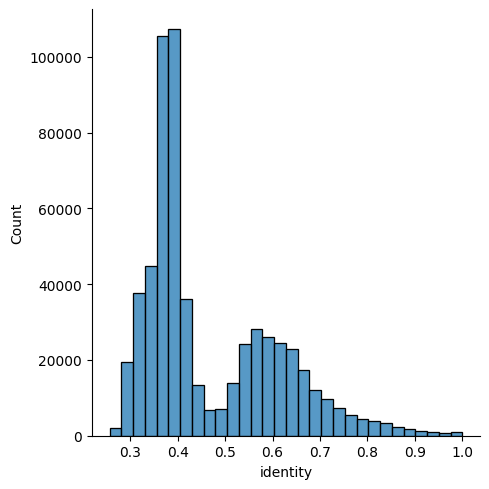

In [11]:
sns.displot(x='identity', data=sequence_similarity_matrix, bins=30)

In [12]:
sequence_similarity_matrix['type'] = sequence_similarity_matrix.apply(
    lambda x: 'Anc' if x['type1'] == 'Anc' or x['type2'] == 'Anc' else 'Ext', axis=1
)
sequence_similarity_matrix

,id1,id2,identity,type1,type2,type
0,Anc_1207_map,Anc_1207_map,1.000000,Anc,Anc,Anc
1,Anc_1207_map,Anc_1213_map,0.743428,Anc,Anc,Anc
2,Anc_1207_map,Anc_1215_map,0.718191,Anc,Anc,Anc
3,Anc_1207_map,Anc_1214_map,0.718191,Anc,Anc,Anc
4,Anc_1207_map,Anc_1216_map,0.703470,Anc,Anc,Anc
...,...,...,...,...,...,...
591356,Nif_Roseiflexus_castenholzii,Nif_archaeon_BMS3Bbin15,0.699892,Nif,Nif,Ext
591357,Nif_Roseiflexus_castenholzii,Nif_Candidatus_Viridilinea_mediisalina,0.830705,Nif,Nif,Ext
591358,Nif_Roseiflexus_castenholzii,Nif_Chloroflexales_bacterium_ZM16-3,0.838947,Nif,Nif,Ext
591359,Nif_Roseiflexus_castenholzii,Nif_Oscillochloris_trichoides,0.842271,Nif,Nif,Ext


<Axes: xlabel='identity', ylabel='Percent'>

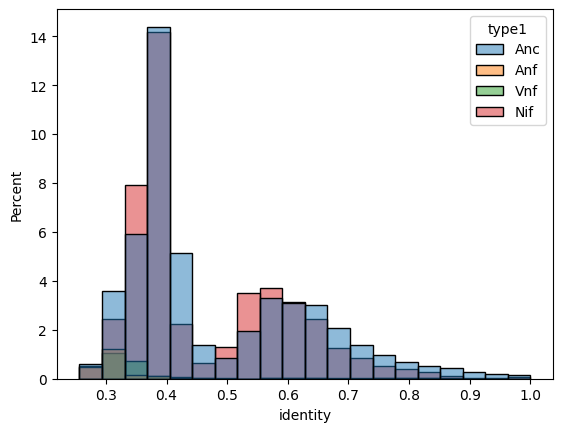

In [13]:
sns.histplot(
    x='identity', 
    data=sequence_similarity_matrix, 
    bins=20, hue='type1', stat='percent'
)